In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchvision
import torchvision.transforms as transforms
from torchvision.io import read_image
from torch.utils import data
from torch.utils.data import random_split,DataLoader
import string
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from tqdm.auto import tqdm


Dataset Link - '/kaggle/input/captchaimgdata/trainset'


In [2]:
BATCH_SIZE=128
VAL_SPLIT=0.2

AFFN_KERNEL=5
AFFN_STRIDE=1
AFFN_DEPTH=2

CRNN_KERNEL=5
CRNN_POOL_KERNEL=2
CRNN_DROPOUT=0.3
CRNN_LATENT=128
LSTM_HIDDEN_DIM=32
VOCAB_SIZE=26+10
OUTPUT_LENGTH=6

SAVE_EPOCH=10
VAL_EPOCH=1
EPOCHS=60
epoch_count = [i for i in range(1,EPOCHS+1)]

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("CUDA is available. Using GPU(s):", torch.cuda.device_count())
else:
    device = torch.device('cpu')
    print("CUDA is not available. Using CPU.")

CUDA is available. Using GPU(s): 1


In [4]:
data = '/kaggle/input/captchaimgdata/trainset'

In [5]:
import os
from torchvision import transforms
from torch.utils.data import DataLoader, random_split, Dataset
import string
import zipfile

def get_dataloaders(data_dir, batch_size=64, val_split=0.2, shuffle=True, num_workers=0):
    #torch.manual_seed(42)
    #torch.cuda.manual_seed(42)
    # Define the character set (vocabulary)
    characters = string.ascii_uppercase + string.digits  # Uppercase + lowercase + digits
    char_to_idx = {char: idx for idx, char in enumerate(characters)}
    vocab_size = len(characters)

    class CustomDataset(Dataset):
        def __init__(self, root_dir, transform=None):
            self.root_dir = root_dir
            self.transform = transform
            self.image_paths = [os.path.join(root_dir, f) for f in os.listdir(root_dir) if f.endswith(('png', 'jpg', 'jpeg'))]
            self.labels = [os.path.basename(f).split('.')[0].upper() for f in self.image_paths]  # Extract filename as label

        def __len__(self):
            return len(self.image_paths)

        def __getitem__(self, idx):
            img_path = self.image_paths[idx]
            image = Image.open(img_path).convert('RGB')
            label_str = self.labels[idx]

            # Convert label string to one-hot encoded tensor
            label_indices = [char_to_idx[c] for c in label_str if c in char_to_idx]  # Map characters to indices
            label_tensor = torch.zeros(len(label_indices),dtype=torch.long)  # One-hot encoding tensor
            for i, index in enumerate(label_indices):
                label_tensor[i] = index  # Set one-hot encoding

            if self.transform:
                image = self.transform(image)

            return image, label_tensor

    transform = transforms.Compose([
        transforms.Resize((64,192)),  # Resize to a fixed size
        transforms.ToTensor(),
        transforms.Grayscale(),
        transforms.Lambda(lambda x: x / 255),
    ])

    dataset = CustomDataset(root_dir=data_dir, transform=transform)
    print(f"Dataset size: {len(dataset)}")  # Print dataset size

    # Compute train-validation split
    total_size = len(dataset)
    val_size = int(total_size * val_split)
    train_size = total_size - val_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, val_loader

In [6]:
train_loader,val_loader=get_dataloaders(data_dir= data, batch_size=BATCH_SIZE, val_split=0.2, shuffle=True)

Dataset size: 26155


In [7]:
train_features_batch, train_labels_batch = next(iter(train_loader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([128, 1, 64, 192]), torch.Size([128, 6]))

In [8]:
def accuracy_fn(y_true, y_pred):
            y_true = y_true.cpu()  
            y_pred = y_pred.cpu()

            y_true = y_true.view(-1)  
            y_pred = y_pred.view(-1)  

            correct = torch.eq(y_true, y_pred).sum().item()
            total_samples = len(y_true) 

            acc = (correct / total_samples)*100
            return acc

In [9]:
class Encoder(nn.Sequential):
    def __init__(self,n,kernel_size,stride):
        super().__init__(
            nn.Conv2d(in_channels=4**(n-1),out_channels=4**n,kernel_size=kernel_size,stride=stride),
            nn.BatchNorm2d(num_features=4**n),
            nn.ReLU(inplace=False)
        )

class Decoder(nn.Sequential):
    def __init__(self,n,kernel_size,stride):
        super().__init__(
            nn.ConvTranspose2d(in_channels=4**n,out_channels=4**(n-1),kernel_size=kernel_size,stride=stride),
            nn.BatchNorm2d(num_features=4**(n-1)),
            nn.ReLU(inplace=False)
        )

In [10]:
class AFFN(nn.Module):
    def __init__(self,n):
        super().__init__()
        self.n=n
        self.alpha=nn.Parameter(torch.randn(n-1).to(device)).to(device)

        #During training, the values of alpha are adjusted by the optimizer to learn the optimal feature fusion strategy. If alpha[i] is close to 0,
        #the network emphasizes the direct path.
        #If alpha[i] is close to 1, it emphasizes the residual path.
        self.encoders=[]
        for i in range(1,n+1):
            self.encoders.append(Encoder(i,AFFN_KERNEL,AFFN_STRIDE).to(device))

        self.decoders=[]
        for i in range(n,0,-1):
            self.decoders.append(Decoder(i,AFFN_KERNEL,AFFN_STRIDE).to(device))

    def forward(self, x):
        residuals = []
        for i, enc in enumerate(self.encoders):
            x = enc(x)
            if i < self.n - 1:
                x = x * (1 - self.alpha[i])
                residuals.append(x * self.alpha[i])        
        for i, dec in enumerate(self.decoders):
            x = dec(x)
         
            if i < self.n - 1:
                x = x + residuals.pop()

        return x

In [11]:
class CRNN(nn.Module):
    def __init__(self, in_channels, kernel_size, pool_kernel_size, dropout, latent_dim, lstm_hidden_dim, vocab_size, output_length=5):
        super().__init__()
        self.lstm_hidden_dim = lstm_hidden_dim
        self.output_length = output_length  
        self.vocab_size = vocab_size

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=in_channels*2, kernel_size=kernel_size, padding=2),
            nn.BatchNorm2d(num_features=in_channels*2),
            nn.ReLU(inplace=False),
            nn.MaxPool2d(kernel_size=pool_kernel_size)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels*2, out_channels=in_channels*4, kernel_size=kernel_size, padding=2),
            nn.BatchNorm2d(num_features=in_channels*4),
            nn.ReLU(inplace=False),
            nn.MaxPool2d(kernel_size=pool_kernel_size)
        )
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(dropout)
        self.latent_fc = nn.LazyLinear(latent_dim)
        self.lstm = nn.LSTM(input_size=latent_dim, hidden_size=lstm_hidden_dim, num_layers=1, batch_first=True)
        self.output_fc = nn.Linear(lstm_hidden_dim, vocab_size)

    def forward(self, x):
        batch_size = x.size(0)
        conv1_out = self.conv1(x)
        conv2_out = self.conv2(conv1_out)
        flattened = self.flatten(conv2_out)
        dropped = self.dropout(flattened)
        latent = self.latent_fc(dropped)

        lstm_input = latent.unsqueeze(1)

        h0 = torch.zeros(1, batch_size, self.lstm_hidden_dim, device=x.device)
        c0 = torch.zeros(1, batch_size, self.lstm_hidden_dim, device=x.device)

        outputs = []

        for _ in range(self.output_length):
            out, (h0, c0) = self.lstm(lstm_input, (h0, c0))  # out shape: (batch_size, 1, lstm_hidden_dim)

            logits = self.output_fc(out.squeeze(1))  # Shape: (batch_size, vocab_size)

            outputs.append(logits)

        outputs = torch.stack(outputs, dim=1)  # Shape: (batch_size, 6, vocab_size)

        return outputs


In [12]:
class CaptchaCrackNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.affn = AFFN(AFFN_DEPTH).to(device)

        self.conv1=nn.Sequential(
            nn.Conv2d(in_channels=1,out_channels=32,kernel_size=5,padding=2),
            nn.ReLU(inplace=False),
            nn.MaxPool2d(kernel_size=2)
        )

        self.conv2=nn.Sequential(
                    nn.Conv2d(in_channels=32,out_channels=48,kernel_size=5,padding=2),
                    nn.ReLU(inplace=False),
                    nn.MaxPool2d(kernel_size=2)
                )

        self.conv3=nn.Sequential(
            nn.Conv2d(in_channels=48,out_channels=64,kernel_size=5,padding=2),
            nn.ReLU(inplace=False),
            nn.MaxPool2d(kernel_size=2)
        )

        self.res=nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=2, padding=2)

        self.crnn=CRNN(64,CRNN_KERNEL,CRNN_POOL_KERNEL,CRNN_DROPOUT,CRNN_LATENT,LSTM_HIDDEN_DIM,VOCAB_SIZE,OUTPUT_LENGTH).to(device)

    def forward(self,x):
        out=self.affn(x)
        res_out=self.res(x)
        conv1_out=self.conv1(out)
        conv2_out=self.conv2(conv1_out+res_out)
        conv3_out=self.conv3(conv2_out)
        output=self.crnn(conv3_out)
        return output


In [13]:
def train(model,train_loader,val_loader,epochs=EPOCHS):
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
    model.to(device)
    train_history=[]
    val_history=[]
    train_acc=[]
    val_acc=[]
    for epoch in range(1,epochs+1):
        print(f"Epoch {epoch}:")
        avg_acc=0
        avg_loss=0
        model.train()
        for batch_num,(X,y) in enumerate(tqdm(train_loader,desc="Progress: ")):

            X=X.to(device)
            y=y.to(device)
            optimizer.zero_grad()
            preds=model(X)

            loss=loss_fn(preds.view(-1, VOCAB_SIZE),y.view(-1))
            loss.backward()
            optimizer.step()

            avg_loss+=loss.item()
            avg_acc+=accuracy_fn(y_true=y.cpu(),y_pred=torch.argmax(preds,dim=2).cpu())


        avg_loss/=len(train_loader)
        avg_acc/=len(train_loader)
        train_acc.append(avg_acc)
        print(f"Train Acc: {avg_acc}%")
        train_history.append(avg_loss)
        print(f"Train Loss: {avg_loss}")

        eval_loss=0
        eval_acc=0
        if VAL_EPOCH and epoch%VAL_EPOCH==0:
            model.eval()
            with torch.no_grad():
                for batch_num,(X,y) in enumerate(tqdm(val_loader,desc="Progress: ")):
                    X=X.to(device)
                    y=y.to(device)
                    preds=model(X)
                    loss=loss_fn(preds.view(-1, VOCAB_SIZE),y.view(-1))
                    eval_acc+=accuracy_fn(y_true=y,y_pred=torch.argmax(preds,dim=2))
                    eval_loss+=loss.item()
                eval_acc/=len(val_loader)
                val_acc.append(eval_acc)
                print(f"Val Acc: {eval_acc}%")
                eval_loss/=len(val_loader)
                val_history.append(eval_loss)
                print(f"Val Loss: {eval_loss}")


        if SAVE_EPOCH and epoch%SAVE_EPOCH==0:
            print("Saving model")
            path=str(epoch)+'.pth'
            torch.save(model.state_dict(), path)
    torch.save(model.state_dict(),'final.pth')

    return train_history,val_history,train_acc,val_acc

In [14]:
model=CaptchaCrackNet().to(device)

train_history,val_history,train_acc,val_acc =train(model,train_loader,val_loader,EPOCHS)

Epoch 1:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 10.480341717479675%
Train Loss: 3.326858844698929


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 10.41454945799458%
Val Loss: 3.27584057319455
Epoch 2:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 11.408578929539294%
Train Loss: 3.2516442464619146


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 12.049091774701534%
Val Loss: 3.2407057634214076
Epoch 3:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 14.319317411924114%
Train Loss: 3.1535783264695145


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 17.072426847579287%
Val Loss: 3.0974495236466573
Epoch 4:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 19.933996019647704%
Train Loss: 2.9619115111304493


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 22.315150516370025%
Val Loss: 2.85502688477679
Epoch 5:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 23.647315379403793%
Train Loss: 2.7617080836761287


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 25.168461144070907%
Val Loss: 2.6763421151696183
Epoch 6:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 26.415989159891602%
Train Loss: 2.6039879467429183


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 28.498372610415295%
Val Loss: 2.5269214990662365
Epoch 7:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 29.71608231707315%
Train Loss: 2.4612627291097873


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 32.09528125686663%
Val Loss: 2.3742042285640066
Epoch 8:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 33.82108528116532%
Train Loss: 2.305638415057485


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 35.86417019153299%
Val Loss: 2.2231097105072766
Epoch 9:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 37.32236619241194%
Train Loss: 2.163658214778435


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 39.65992478759246%
Val Loss: 2.0730821853730736
Epoch 10:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 40.29831470189701%
Train Loss: 2.0249670707597964


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 42.12312541199736%
Val Loss: 1.951240821582515
Saving model
Epoch 11:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 42.90766852981029%
Train Loss: 1.8979208600230333


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 44.325651871383585%
Val Loss: 1.8276134903837995
Epoch 12:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 45.28809917005418%
Train Loss: 1.7845247358810612


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 46.22132612795723%
Val Loss: 1.727574711892663
Epoch 13:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 47.29468368902441%
Train Loss: 1.685230279841074


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 48.51057231011499%
Val Loss: 1.6245770163652373
Epoch 14:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 49.00533536585369%
Train Loss: 1.5946908854856723


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 49.83560160770528%
Val Loss: 1.5470544477788413
Epoch 15:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 50.73424796747968%
Train Loss: 1.5141574791291865


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 51.76818396140041%
Val Loss: 1.460240067505255
Epoch 16:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 52.350313346883446%
Train Loss: 1.439665947745486


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 53.31549155863181%
Val Loss: 1.3998918213495395
Epoch 17:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 54.170212991192415%
Train Loss: 1.3726922106452104


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 55.185301536292386%
Val Loss: 1.3294393958114996
Epoch 18:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 55.65585831639563%
Train Loss: 1.3078105384256782


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 56.3403246996997%
Val Loss: 1.2700730155153972
Epoch 19:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 57.21523543360433%
Train Loss: 1.2504368380802433


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 57.46330362374568%
Val Loss: 1.2221997801850482
Epoch 20:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 59.0654640921409%
Train Loss: 1.195378650252412


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 58.84964614004246%
Val Loss: 1.178057272259782
Saving model
Epoch 21:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 60.5494156504065%
Train Loss: 1.1399379408941037


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 60.75338867831246%
Val Loss: 1.1239085546353969
Epoch 22:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 62.254139142953925%
Train Loss: 1.0894478428654555


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 62.74802813484217%
Val Loss: 1.0684926364479996
Epoch 23:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 64.21467437330624%
Train Loss: 1.0397878572708223


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 64.27313365194463%
Val Loss: 1.0204536551382484
Epoch 24:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 65.85042979336045%
Train Loss: 0.9948552945038167


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 65.64774568776095%
Val Loss: 0.9735312461853027
Epoch 25:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 67.74834857723575%
Train Loss: 0.949925348889537


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 67.47112012927562%
Val Loss: 0.9348102691696911
Epoch 26:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 69.41882621951221%
Train Loss: 0.9087343259555537


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 68.51890953453452%
Val Loss: 0.9057187612463788
Epoch 27:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 70.89007452574525%
Train Loss: 0.8711018304272395


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 70.54845432322567%
Val Loss: 0.8588516930254494
Epoch 28:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 72.4852324695122%
Train Loss: 0.8325494204352542


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 71.850509045631%
Val Loss: 0.8287882790332888
Epoch 29:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 74.06572874322494%
Train Loss: 0.7952329796261903


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 71.89253849886471%
Val Loss: 0.8100619068959864
Epoch 30:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 75.35987254403797%
Train Loss: 0.763234299493999


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 74.62639850216068%
Val Loss: 0.7577056245106023
Saving model
Epoch 31:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 77.02611576897017%
Train Loss: 0.7285748189542351


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 76.36156545264775%
Val Loss: 0.7187865812604021
Epoch 32:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 78.39610857046073%
Train Loss: 0.6939091028236761


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 77.42300227056323%
Val Loss: 0.6944300953934832
Epoch 33:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 80.05748221544715%
Train Loss: 0.6604127120680925


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 79.24906613931006%
Val Loss: 0.6574882167141612
Epoch 34:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 81.5323827066396%
Train Loss: 0.628835058793789


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 78.45903258441369%
Val Loss: 0.6586127034047755
Epoch 35:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 82.5268885501355%
Train Loss: 0.5998392301361736


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 81.28473366659344%
Val Loss: 0.6070861220359802
Epoch 36:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 83.76100948509482%
Train Loss: 0.5726496326487239


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 82.61634347762399%
Val Loss: 0.5742183749268694
Epoch 37:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 84.97491107723575%
Train Loss: 0.5446857244866651


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 83.15159671866988%
Val Loss: 0.5531362978423514
Epoch 38:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 86.04695968834689%
Train Loss: 0.5205356809424191


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 84.48686872848458%
Val Loss: 0.5245227377589156
Epoch 39:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 87.14282689701898%
Train Loss: 0.49407965435487466


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 85.56567237969675%
Val Loss: 0.5001122348192262
Epoch 40:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 87.9322281504065%
Train Loss: 0.47132321774232677


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 86.2156840529554%
Val Loss: 0.48483175911554477
Saving model
Epoch 41:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 88.86623475609755%
Train Loss: 0.4473681973247993


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 87.206795209844%
Val Loss: 0.4619673926655839
Epoch 42:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 89.92827955623304%
Train Loss: 0.42179568220929403


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 88.37475051270782%
Val Loss: 0.43178122581505196
Epoch 43:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 90.57175220189704%
Train Loss: 0.4025666324830637


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 88.75559057533142%
Val Loss: 0.4124969985426926
Epoch 44:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 91.02774601964771%
Train Loss: 0.38582187527563516


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 88.54183833223469%
Val Loss: 0.4102788422165847
Epoch 45:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 91.88860306571814%
Train Loss: 0.36572763469161057


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 89.70101008020215%
Val Loss: 0.3828582458379792
Epoch 46:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 92.44982215447156%
Train Loss: 0.34832332937455757


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 90.06107860909692%
Val Loss: 0.3720126937075359
Epoch 47:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 93.23948805894305%
Train Loss: 0.32730841545796974


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 91.09782419614733%
Val Loss: 0.3496407844671389
Epoch 48:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 93.53891429539293%
Train Loss: 0.31498213030579614


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 91.14157030506117%
Val Loss: 0.33730607425294273
Epoch 49:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 93.88984163279133%
Train Loss: 0.3044952306805587


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 91.80213941075222%
Val Loss: 0.3211418273972302
Epoch 50:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 94.48154852642274%
Train Loss: 0.2856556377032908


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 92.61634919980955%
Val Loss: 0.30533395307820016
Saving model
Epoch 51:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 94.9875613990515%
Train Loss: 0.27102464055869635


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 91.35071618874971%
Val Loss: 0.3221039074223216
Epoch 52:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 95.32589134485087%
Train Loss: 0.25876448984916617


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 93.23194192668277%
Val Loss: 0.2801310779844842
Epoch 53:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 95.61441395663957%
Train Loss: 0.248088289052248


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 93.94575596938402%
Val Loss: 0.2625052016682741
Epoch 54:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 95.94808604336046%
Train Loss: 0.23657925735886504


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 94.07939761407751%
Val Loss: 0.2542264970337472
Epoch 55:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 96.1201621781843%
Train Loss: 0.2278351444841885


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 94.38793786164213%
Val Loss: 0.24731033313565137
Epoch 56:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 96.38661288956638%
Train Loss: 0.21657403549406587


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 94.61659639822749%
Val Loss: 0.2366326258676808
Epoch 57:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 96.64549457994583%
Train Loss: 0.2071566604441259


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 93.43762588808319%
Val Loss: 0.26076607406139374
Epoch 58:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 96.93772230691056%
Train Loss: 0.1967972487029506


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 95.18944439866694%
Val Loss: 0.21741764102040267
Epoch 59:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 97.05263380758805%
Train Loss: 0.19010302124590409


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 95.3978177872995%
Val Loss: 0.20939413621658232
Epoch 60:


Progress:   0%|          | 0/164 [00:00<?, ?it/s]

Train Acc: 97.13218792344173%
Train Loss: 0.18561056110917068


Progress:   0%|          | 0/41 [00:00<?, ?it/s]

Val Acc: 95.80921432102835%
Val Loss: 0.20091186827275812
Saving model


In [15]:
loaded_model = CaptchaCrackNet() 

state_dict = torch.load('final.pth', map_location=torch.device('cpu')) 

loaded_model.load_state_dict(state_dict) 

loaded_model.eval()

CaptchaCrackNet(
  (affn): AFFN()
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 48, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(48, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res): Conv2d(1, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (crnn): CRNN(
    (conv1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, d

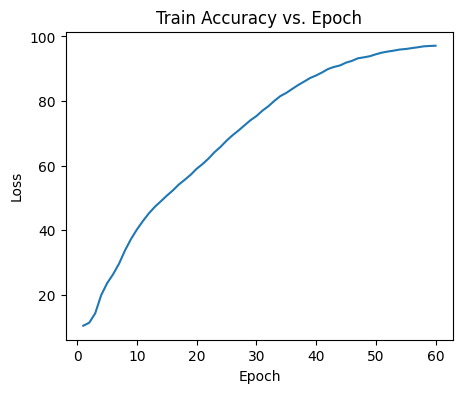

In [16]:
import matplotlib.pyplot as plt
import numpy as np

def plot_predictions(epochs,losses,predictions=None):
  plt.figure(figsize=(5,4))
  plt.plot(epochs, losses)
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Train Accuracy vs. Epoch')
  plt.show()
plot_predictions(epoch_count,train_acc)

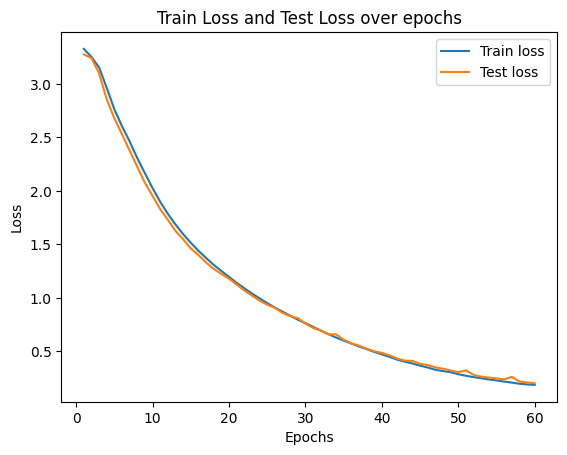

In [17]:

def plot_loss(x1,x2,epochs):
    fig, ax = plt.subplots()
    ax.plot(epochs,x1, label='Train loss')
    ax.plot(epochs,x2, label='Test loss')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title('Train Loss and Test Loss over epochs')
    ax.legend()
    plt.show()

plot_loss(train_history,val_history,epoch_count)

In [18]:
characters = string.ascii_uppercase + string.digits
idx_to_char = {idx: char for idx, char in enumerate(characters)}
def to_text(arr):
    ans=''
    for c in arr:
        ans=ans+idx_to_char[c.item()]
    return ans

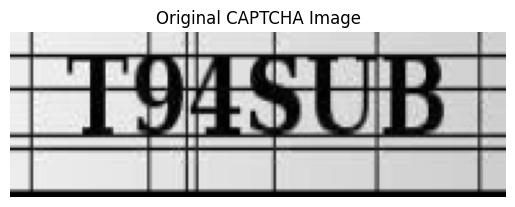

True : T94SUB
Pred : T4SUB


In [19]:
from itertools import groupby

def to_text(pred_tensor):
    pred_indices = pred_tensor.cpu().numpy().tolist()
    result = ''.join([idx_to_char[idx] for idx, _ in groupby(pred_indices) if idx != VOCAB_SIZE - 1])
    return result

import matplotlib.pyplot as plt

model.eval()  # Set to eval mode

with torch.no_grad():
    for X, y in train_loader:
        # Select one sample
        X_single = X[0]
        y_single = y[0]

        # Show original image
        plt.imshow(X_single.numpy().squeeze(), cmap='gray')
        plt.title("Original CAPTCHA Image")
        plt.axis("off")
        plt.show()

        # Model output
        input_tensor = X_single.unsqueeze(0).to(device)
        output = model(input_tensor)  # [W, B, VOCAB_SIZE]
        output = F.log_softmax(output, dim=2)
        pred = output.argmax(dim=2).squeeze(1)  # [W]

        # Decode prediction
        pred_text=''
        for i in pred:
            pred_text+= to_text(i)
        true_text = ''.join([idx_to_char[c.item()] for c in y_single if c.item() != -1])

        print(f"True : {true_text}")
        print(f"Pred : {pred_text}")
        break

In [20]:
def get_predictions_and_labels(model, dataloader):
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Collecting predictions"):
            images = images.to(device)
            outputs = model(images)
            outputs = F.log_softmax(outputs, dim=2)
            preds = outputs.argmax(dim=2).permute(1, 0)  # [B, W]

            all_preds.extend(preds.cpu())
            all_targets.extend(labels.cpu())

    return all_preds, all_targets

In [21]:
val_preds, val_targets = get_predictions_and_labels(model, val_loader)

In [22]:
preds = []
targets = []
for i in val_preds:
    for j in i:
        preds.append(j.item())
for i in val_targets:
    for j in i:
        targets.append(j.item())

In [23]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
import numpy as np
def Confmatrix(y_pred,targets):
    confmat = ConfusionMatrix(num_classes=VOCAB_SIZE, task='multiclass')
    y_pred = torch.tensor(y_pred, dtype=torch.int64) 
    targets = torch.tensor(targets, dtype=torch.int64)
    
    confmat_tensor = confmat(preds=y_pred,target=targets) 

    fig, ax = plot_confusion_matrix(
        conf_mat=confmat_tensor.cpu().numpy(), # Convert back to NumPy for plotting
        class_names=list(characters), # turn the row and column labels into class names
        figsize=(10, 7)
    );
   

/usr/local/lib/python3.11/dist-packages/mlxtend/plotting/plot_confusion_matrix.py:102: RuntimeWarning: invalid value encountered in divide
  normed_conf_mat = conf_mat.astype("float") / total_samples


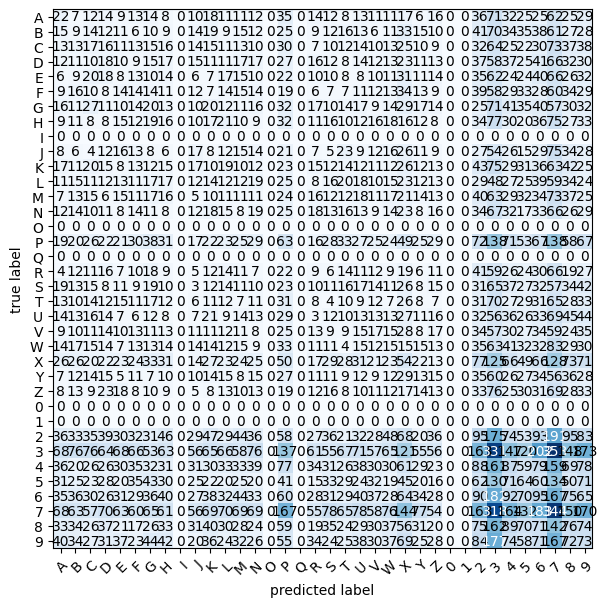

In [24]:
Confmatrix(preds,targets)